In [2]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt
import heapq

In [180]:
# Initial conditions
n = 30 # number of trash
m = 5 # size of grid
k = 6 # number of agents (must be an even number)
mu = [3, 2] # center of trash pile
sig = [[0.1, 0], [0, 0.1]] # spread of pile
var = 0.1 # error in measurements

field = np.zeros((m,m))# array of trash pieces dispersed on field
visits = np.zeros((k,m,m))# array to track number of visits to each gridpoint
reward = np.zeros((k,m,m))# array of sum of rewards from each gridpoint
expected_mean = np.zeros((k,m,m)) # array of expected mean of each gridpoint

T = n # number of time steps
delta = 1 # amount reward decreases per visit
xi = 2 # constant xi > 1
gamma = 3 # max message length

messageSent = {}# dict {agent: list of messages to send - tuple [agent, time, arm, reward]}
messageRec = {}# dict {agent: list of messages received - tuple [agent, time, arm, reward]}

regret = []

In [181]:
for i in range(k):
    messageSent[i] = []
    messageRec[i] = []
    regret.append([0])

In [182]:
# Initialize communication network
# If graph[i][j] = 1 then there is an edge between agents i and j
# Array must be symmetric

# graph = np.ones((k,k))
# Initialize communication network
degree = 3

graph = np.identity(k)
if degree % 2 == 0:
    count = int(degree/2)
    for j in range(count):
        # make vertex for every (i +1) steps away
        for i in range(k):
            neighbor = int(i + j + 1)
            if neighbor > (k-1):
                neighbor = neighbor - k
            graph[i][neighbor] = 1
            graph[neighbor][i] = 1
else:
    count = int((degree-1)/2 + 1)
    for j in range(count):
        # make vertex for every n/2 - i steps away
        for i in range(k):
            neighbor = int(i + k/2 - j)
            if neighbor > (k-1):
                neighbor = neighbor - k
            graph[i][neighbor] = 1
            graph[neighbor][i] = 1
print(graph)

#graph = np.array([[1, 1, 1, 1, 0, 0], [1, 1, 0, 1, 1, 0], [1, 0, 1, 0, 1, 1], [1, 1, 0, 1, 0, 1], [0, 1, 1, 0, 1, 1], [0, 0, 1, 1, 1, 1]])


[[1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1.]]


In [183]:
# Initialize field
trash = np.random.multivariate_normal(mu, sig, n)
for i in range(n):
    x = int(trash[i][0])
    y = int(trash[i][1])
    field[x][y] += 1
    
print(field)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 7. 8. 0. 0.]
 [0. 8. 7. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [184]:
# Initialize agents
t = 0
for i in range(k):
    for x in range(m):
        for y in range(m):
            measure = round(np.random.normal(field[x][y], var),1)
            reward[i][x][y] += measure
            visits[i][x][y] += 1
    
    # Calculate expected mean
    expected_mean[i] = np.divide(reward[i], visits[i])
    

In [185]:
t += 1
while np.max(field) > 0:
    print("t: {}".format(t))
    index = []
    field_new = field.reshape(m**2).tolist()
    c = heapq.nlargest(k, range(len(field_new)), key = field_new.__getitem__)
    for i in range(k):        
        # Select arm with highest expected Q value
        Q = expected_mean[i] + var*np.divide(math.sqrt(2*(xi + 1)*math.log(t)),np.sqrt(visits[i]))
        Q_new = Q.reshape(m**2).tolist()
        b = heapq.nlargest(k, range(len(Q_new)), key=Q_new.__getitem__)
        ind = np.unravel_index(b[i], Q.shape)
        measure = np.round(np.random.normal(field[ind], var),1)
        index.append(ind)
            
        print(ind)
        print(Q)
        print(measure)
        
        # Calculate regret
        optimal_ind = np.unravel_index(c[i], field.shape)
        # optimal_ind = np.unravel_index(np.argmax(field), field.shape)
        # print("opt ind: {}".format(optimal_ind))
        max_reward = field[optimal_ind]
        actual_reward = field[ind]
        # print(max_reward)
        # print(actual_reward)
        #if actual_reward < 0:
         #   actual_reward = 0
        regret[i].append(max_reward - actual_reward)
            
        # Make message to send to neighboring agents
        message = (t, i, ind, measure)
        send = messageSent[i]
        if len(send) == gamma:
            send.pop(0)
        send.append(message)
        messageSent[i] = send
        
    # Pick up trash from selected grid points
    for i in range(len(index)):
        ind = index[i]
        if field[ind] > 0:
            field[ind] -= 1
                
    
    # receive messages from neighbors and adjust expected mean
    for i in range(k):
        print(i)
        new_visits= np.zeros((m,m))
        # compare new messages with history of messages and skip any repeats
        for j in range(k):
            if graph[i][j] == 1:
                received = messageRec[i]
                sent = messageSent[j]
                for l in range(len(sent)):
                    msg = sent[l]
                    if received.count(msg) == 0:
                        received.append(msg)
                        ind = msg[2]
                        visits[i][ind] += 1
                        new_visits[ind] += 1
                        reward[i][ind] += msg[3]
                messageRec[i] = received
        
        # calculate expected mean
        reward[i] -= np.multiply(new_visits, visits[i])
        # expected_mean[i] = (expected_mean[i] -1) + np.divide(new_reward[i], visits[i])
        expected_mean[i] = np.divide(reward[i], visits[i])
        print(reward[i])
        print(visits[i])
        print(expected_mean[i])
    
    print(field)
    t += 1 



    

t: 1
(2, 2)
[[ 0.1 -0.2  0.   0.   0. ]
 [ 0.3  0.   0.1  0.1 -0.2]
 [ 0.   7.1  8.2  0.1  0.1]
 [ 0.   8.   6.9  0.   0.1]
 [-0.1  0.1  0.   0.   0. ]]
8.1
(3, 1)
[[-0.2  0.  -0.1  0.   0. ]
 [ 0.1  0.2  0.1 -0.2  0.1]
 [ 0.1  7.1  8.1  0.1  0.1]
 [-0.1  8.   7.   0.  -0.2]
 [ 0.1  0.   0.1 -0.1  0.1]]
7.9
(3, 2)
[[-0.2  0.   0.  -0.1 -0.1]
 [ 0.1  0.   0.   0.1  0. ]
 [ 0.1  6.9  8.1  0.1  0. ]
 [ 0.   7.9  7.  -0.3  0. ]
 [ 0.1  0.1  0.   0.1 -0.1]]
7.0
(2, 1)
[[-0.1  0.  -0.1  0.1  0. ]
 [ 0.   0.   0.1  0.1 -0.1]
 [ 0.2  6.9  7.8 -0.1  0. ]
 [ 0.1  8.   7.2 -0.3  0. ]
 [ 0.1  0.   0.  -0.1  0.1]]
7.0
(2, 4)
[[ 0.   0.1  0.   0.1  0. ]
 [ 0.1 -0.1  0.  -0.2  0. ]
 [-0.1  7.1  8.   0.1  0.2]
 [ 0.1  8.   6.9  0.1 -0.1]
 [-0.1  0.1  0.   0.2  0.2]]
-0.1
(4, 1)
[[ 0.1  0.1  0.  -0.1 -0.1]
 [ 0.1  0.1  0.1  0.1  0. ]
 [ 0.1  7.   7.9 -0.1  0.1]
 [ 0.   7.8  6.9  0.2 -0.1]
 [ 0.   0.2  0.1 -0.1 -0.2]]
0.2
0
[[ 0.1 -0.2  0.   0.   0. ]
 [ 0.3  0.   0.1  0.1 -0.2]
 [ 0.  12.1 14.3  0.1 -2

 [1. 2. 1. 2. 2.]]
[[-1.15       -1.66666667  0.         -0.1        -0.1       ]
 [-0.95        0.          0.          0.1         0.        ]
 [ 0.1         3.63333333  6.1         0.1        -1.05      ]
 [ 0.          4.93333333  4.66666667 -0.3         0.        ]
 [ 0.1        -0.85        0.         -1.         -1.05      ]]
3
[[-2.2 -2.  -0.1  0.1  0. ]
 [-2.   0.   0.1  0.1 -0.1]
 [ 0.2 13.2 18.  -0.1  0. ]
 [ 0.1 17.8 11.2 -0.3  0. ]
 [ 0.1 -1.8  0.  -0.1  0.1]]
[[2. 2. 1. 1. 1.]
 [2. 1. 1. 1. 1.]
 [1. 5. 3. 1. 1.]
 [1. 6. 2. 1. 1.]
 [1. 2. 1. 1. 1.]]
[[-1.1        -1.         -0.1         0.1         0.        ]
 [-1.          0.          0.1         0.1        -0.1       ]
 [ 0.2         2.64        6.         -0.1         0.        ]
 [ 0.1         2.96666667  5.6        -0.3         0.        ]
 [ 0.1        -0.9         0.         -0.1         0.1       ]]
4
[[ 0.  -1.9  0.   0.1  0. ]
 [ 0.1 -0.1  0.  -0.2  0. ]
 [-0.1 11.1 18.2  0.1 -1.9]
 [ 0.1 17.8 15.9  0.1 -0.1]
 

 [  0.   -1.6  -1.9  -0.1  -0.2]]
[[ 2.  2.  2.  2.  1.]
 [ 2.  2.  1.  2.  1.]
 [ 3. 11.  1.  1.  1.]
 [ 2.  6. 10.  1.  1.]
 [ 1.  2.  2.  1.  1.]]
[[-1.         -0.95       -0.9        -1.1        -0.1       ]
 [-0.95       -0.9         0.1        -0.9         0.        ]
 [-2.03333333 -2.80909091  7.9        -0.1         0.1       ]
 [-1.05        1.78333333 -1.93        0.2        -0.1       ]
 [ 0.         -0.8        -0.95       -0.1        -0.2       ]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
t: 10
(2, 2)
[[-0.68717391 -0.83717391  0.37169222 -1.4854034   0.37169222]
 [-0.53717391  0.37169222  0.47169222  0.47169222  0.17169222]
 [-0.78717391 -2.68793058  3.23507605 -0.73717391 -0.73717391]
 [-0.78717391  1.78622581  1.00174271 -0.68717391  0.47169222]
 [ 0.27169222  0.47169222  0.37169222 -0.78717391 -0.73717391]]
3.1
(3, 1)
[[-1.55207006 -1.45207006 -0.68717391 -1.4854034   0.37169222]
 [-1.3854034  -0.58717391  0.47169222 -0

In [186]:
print(field)
print(t)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
14


[[0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 3.0, 0.0, 0.0, 1.0, 0.0], [0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 1.0, -1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
[[0. 0. 0. 0. 1. 1. 1. 3. 3. 6. 6. 6. 7. 7.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 2. 2. 2. 2. 2. 2. 2. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


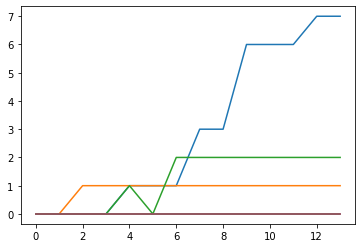

In [187]:
print(regret)
cum_regret = np.cumsum(np.array(regret), axis = 1)
print(cum_regret)
for i in range(k):
    plt.plot(np.arange(t), cum_regret[i])
plt.show()